In [187]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [188]:
df = pd.read_csv('timing_flattern_3列.csv')

In [189]:
def get_ratings_matrix(df, train_size=0.75):
    user_to_row = {}
    movie_to_column = {}
    df_values = df.values[:,1:]
    n_dims = 10
    parameters = {}

    uniq_users = np.unique(df_values[:,0])
    uniq_movies = np.unique(df_values[:,1])

    for i, user_id in enumerate(uniq_users):
        user_to_row[user_id] = i

    for j, movie_id in enumerate(uniq_movies):
        movie_to_column[movie_id] = j

    n_users = len(uniq_users)
    n_movies = len(uniq_movies)

    R = np.zeros((n_users, n_movies))

#     df_copy = df.copy()
#     train_set = df_copy.sample(frac=train_size, random_state=0)
#     test_set = df_copy.drop(train_set.index)
    train_set,test_set = train_test_split(df_values, test_size=0.2)
    for r in train_set:
        i = r[0]
        j = r[1]
        R[int(i),int(j)] = r[2]

    return R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column


In [190]:
R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column = get_ratings_matrix(df, 0.8)

print("R.shape",R.shape)
print("n_users:",n_users)
print("n_movies:",n_movies)
print("user_to_row:",user_to_row)
# print("movie_to_column:",movie_to_column)
# print("R:",R)

R.shape (1500, 18)
n_users: 1500
n_movies: 18
user_to_row: {0.0: 0, 1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4, 5.0: 5, 6.0: 6, 7.0: 7, 8.0: 8, 9.0: 9, 10.0: 10, 11.0: 11, 12.0: 12, 13.0: 13, 14.0: 14, 15.0: 15, 16.0: 16, 17.0: 17, 18.0: 18, 19.0: 19, 20.0: 20, 21.0: 21, 22.0: 22, 23.0: 23, 24.0: 24, 25.0: 25, 26.0: 26, 27.0: 27, 28.0: 28, 29.0: 29, 30.0: 30, 31.0: 31, 32.0: 32, 33.0: 33, 34.0: 34, 35.0: 35, 36.0: 36, 37.0: 37, 38.0: 38, 39.0: 39, 40.0: 40, 41.0: 41, 42.0: 42, 43.0: 43, 44.0: 44, 45.0: 45, 46.0: 46, 47.0: 47, 48.0: 48, 49.0: 49, 50.0: 50, 51.0: 51, 52.0: 52, 53.0: 53, 54.0: 54, 55.0: 55, 56.0: 56, 57.0: 57, 58.0: 58, 59.0: 59, 60.0: 60, 61.0: 61, 62.0: 62, 63.0: 63, 64.0: 64, 65.0: 65, 66.0: 66, 67.0: 67, 68.0: 68, 69.0: 69, 70.0: 70, 71.0: 71, 72.0: 72, 73.0: 73, 74.0: 74, 75.0: 75, 76.0: 76, 77.0: 77, 78.0: 78, 79.0: 79, 80.0: 80, 81.0: 81, 82.0: 82, 83.0: 83, 84.0: 84, 85.0: 85, 86.0: 86, 87.0: 87, 88.0: 88, 89.0: 89, 90.0: 90, 91.0: 91, 92.0: 92, 93.0: 93, 94.0: 94, 95.0: 95, 

In [191]:
parameters = {}


# 初始化U，V
def initialize_parameters(lambda_U, lambda_V):
    U = np.zeros((n_dims, n_users), dtype=np.float64)
    V = 1000*np.random.normal(0.0, 1.0 / lambda_V, (n_dims, n_movies))
    
    parameters['U'] = U
    parameters['V'] = V
    parameters['lambda_U'] = lambda_U
    parameters['lambda_V'] = lambda_V

In [192]:
#更新U，V
def update_parameters():
    U = parameters['U']
    V = parameters['V']
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    
    for i in range(n_users):
        V_j = V[:, R[i, :] > 0]
        U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * np.identity(n_dims)), np.dot(R[i, R[i, :] > 0], V_j.T))
        
    for j in range(n_movies):
        U_i = U[:, R[:, j] > 0]
        V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * np.identity(n_dims)), np.dot(R[R[:, j] > 0, j], U_i.T))
        
    parameters['U'] = U
    parameters['V'] = V

In [193]:
# let's implement the Log-a posteriori:

def log_a_posteriori():
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    U = parameters['U']
    V = parameters['V']
    
    UV = np.dot(U.T, V)
    R_UV = (R[R > 0] - UV[R > 0])
    
    return -0.5 * (np.sum(np.dot(R_UV, R_UV.T)) + lambda_U * np.sum(np.dot(U, U.T)) + lambda_V * np.sum(np.dot(V, V.T)))

predict function allows us to predict the rating value given the user_id and the movie_id parameters. The value has been scaled within the range 0-5


In [194]:
def predict(user_id, movie_id):
    U = parameters['U']
    V = parameters['V']
    
#     r_ij = U[:, user_to_row[user_id]].T.reshape(1, -1) @ V[:, movie_to_column[movie_id]].reshape(-1, 1)
    r_ij = U[:, user_id].T.reshape(1, -1) @ V[:, movie_id].reshape(-1, 1)
    max_rating = parameters['max_rating']
    min_rating = parameters['min_rating']

    return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) * 2000.0

The evaluate function will calculate the RMSE of the model given a dataset (train or test).


In [195]:
#计算 RMSE
def evaluate(dataset):
    ground_truths = []
    predictions = []
    
#     for index, row in dataset.iterrows():
#         ground_truths.append(row.loc['rating'])
#         predictions.append(predict(row.loc['userId'], row.loc['movieId']))
    for r in dataset:
        ground_truths.append(r[2])
        predictions.append(predict( int(r[0]),int(r[1]) ))
    return mean_squared_error(ground_truths, predictions, squared=False)

In [196]:
def update_max_min_ratings():
    U = parameters['U']
    V = parameters['V']

    R = U.T @ V
    min_rating = np.min(R)
    max_rating = np.max(R)

    parameters['min_rating'] = min_rating
    parameters['max_rating'] = max_rating

训练函数


In [197]:
def train(n_epochs):
    initialize_parameters(3, 3)
    log_aps = []
    rmse_train = []
    rmse_test = []

    update_max_min_ratings()
    rmse_train.append(evaluate(train_set))
    rmse_test.append(evaluate(test_set))
    
    for k in range(n_epochs):
        update_parameters()
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)

        if (k + 1) % 10 == 0:
            update_max_min_ratings()

            rmse_train.append(evaluate(train_set))
            rmse_test.append(evaluate(test_set))
            print('Log p a-posteriori at iteration', k + 1, ':', log_ap)

    update_max_min_ratings()

    return log_aps, rmse_train, rmse_test

In [198]:
log_ps, rmse_train, rmse_test = train(150)

Log p a-posteriori at iteration 10 : -637846.2683614471
Log p a-posteriori at iteration 20 : -661490.113177748
Log p a-posteriori at iteration 30 : -544978.7818193933
Log p a-posteriori at iteration 40 : -522246.3612448413
Log p a-posteriori at iteration 50 : -521531.0097663896
Log p a-posteriori at iteration 60 : -520818.1893848011
Log p a-posteriori at iteration 70 : -520107.88778202405
Log p a-posteriori at iteration 80 : -519400.09252710437
Log p a-posteriori at iteration 90 : -518694.7914679559
Log p a-posteriori at iteration 100 : -517991.9724242745
Log p a-posteriori at iteration 110 : -517291.6233439299
Log p a-posteriori at iteration 120 : -516593.732157255
Log p a-posteriori at iteration 130 : -515898.286884979
Log p a-posteriori at iteration 140 : -515205.2757385392
Log p a-posteriori at iteration 150 : -514514.687012708


画图


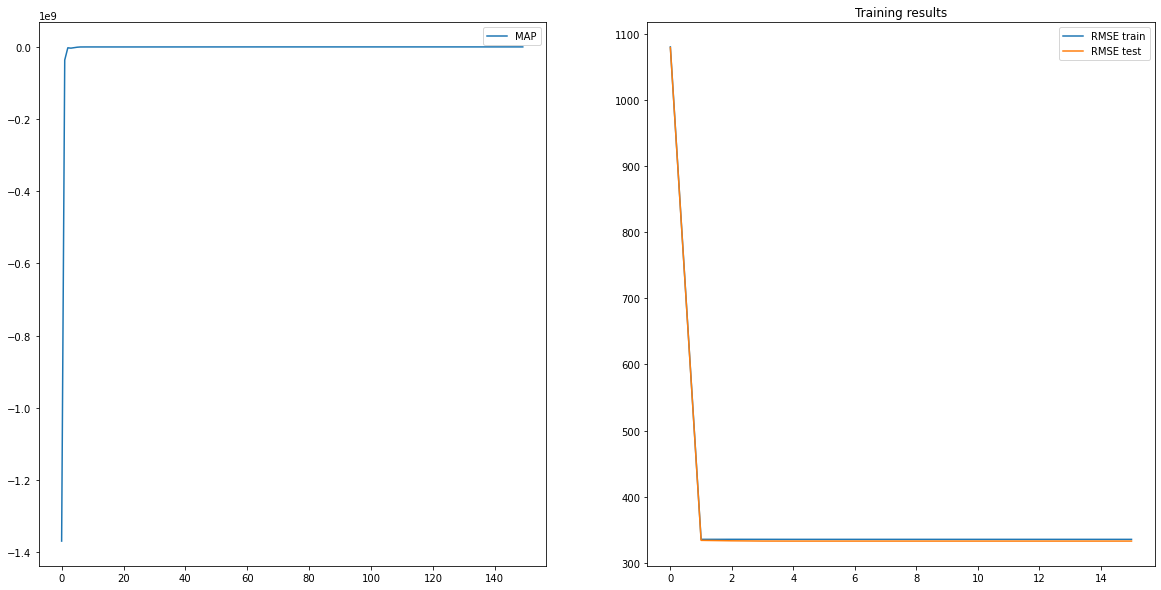

In [199]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title('Training results')
ax1.plot(np.arange(len(log_ps)), log_ps, label='MAP')
ax1.legend()

ax2.plot(np.arange(len(rmse_train)), rmse_train, label='RMSE train')
ax2.plot(np.arange(len(rmse_test)), rmse_test, label='RMSE test')
ax2.legend()

plt.show()

In [200]:
print('RMSE of training set:', evaluate(train_set))
print('RMSE of testing set:', evaluate(test_set))

RMSE of training set: 335.6062875207561
RMSE of testing set: 332.98651520175076
